In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Import local modules

### Define helper plot function

In [2]:
def plotnatpft(variable, colormap='magma_r'):
    fg = variable.plot(x='lon',y='lat',col='natpft', col_wrap=4, cmap=colormap, 
                   transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), add_colorbar=False)

    for ax in fg.axes.flat:
        ax.coastlines() 

    # color bar
    fg.add_colorbar(orientation="vertical", shrink=0.6, anchor=(1.5, 0.5))
    plt.subplots_adjust(hspace=-0.65)

### Import data

In [3]:
luh2_static_file = '/home/glemieux/Data/luh2/staticData_quarterdeg.nc'
regrid_target_file = '/home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
clm_surface_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc'
clm_forest_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhforest_deg025.nc'
clm_pasture_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhpasture_deg025.nc'
clm_other_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc'
filelist = [clm_surface_file, clm_forest_file, clm_pasture_file, clm_other_file]

In [4]:
ds_static = xr.open_dataset(luh2_static_file)

In [5]:
ds_target = xr.open_dataset(regrid_target_file)

In [6]:
ds_clmsurf = xr.open_dataset(clm_surface_file)

In [7]:
ds_forest = xr.open_dataset(clm_forest_file)

## Prep data

### Target dataset

Rename and add lat/lon as dimensions/coordinates

In [8]:
# Rename the lat/lon dimensions
ds_target = ds_target.rename_dims(dims_dict={'lsmlat':'lat','lsmlon':'lon'})

# Add lat/lon as a coordinate
ds_target['lon'] = ds_target.LONGXY.isel(lat=0)
ds_target['lat'] = ds_target.LATIXY.isel(lon=0)

Mask the data

In [9]:
ds_target["mask"] = ds_target.PCT_NATVEG > 0.

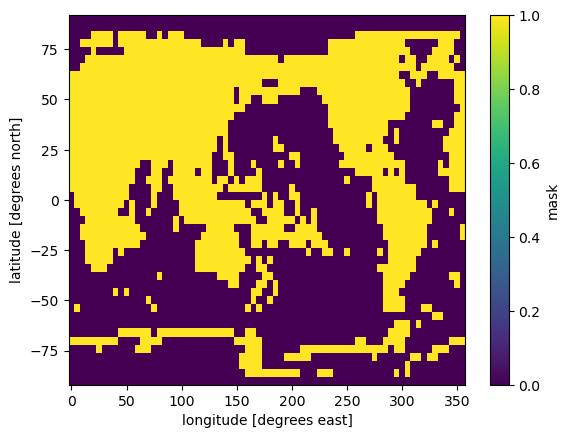

In [10]:
ds_target.mask.plot()

### CLM5 Surface dataset

Create a lat/lon coordinate from the LAT/LON variable

In [11]:
ds_clmsurf['lat'] = ds_clmsurf.LAT
ds_clmsurf['lon'] = ds_clmsurf.LON

Compute a mask for the other CLM5 landuse-pft data

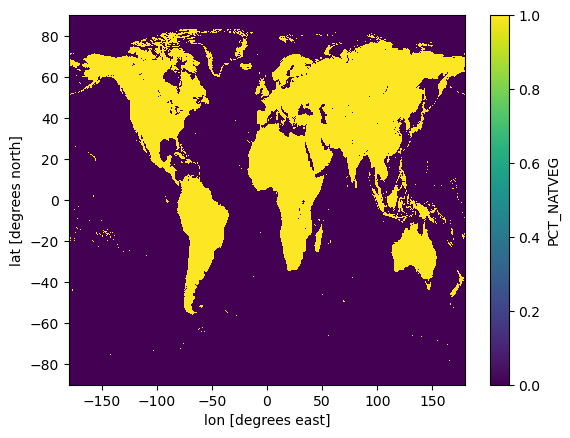

In [12]:
mask_clmsurf = ds_clmsurf.PCT_NATVEG > 0.
mask_clmsurf.plot()

In [13]:
ds_clmsurf

<xarray.Dataset>
Dimensions:      (natpft: 15, cft: 64, lat: 720, lon: 1440)
Coordinates:
  * natpft       (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft          (cft) int32 15 16 17 18 19 20 21 22 ... 71 72 73 74 75 76 77 78
  * lat          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables: (12/19)
    EDGEN        float32 ...
    EDGEE        float32 ...
    EDGES        float32 ...
    EDGEW        float32 ...
    LAT          (lat) float32 ...
    LATIXY       (lat, lon) float32 ...
    ...           ...
    PCT_WETLAND  (lat, lon) float32 ...
    PCT_URBAN    (lat, lon) float32 ...
    PCT_NATVEG   (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    PCT_CROP     (lat, lon) float32 ...
    PCT_NAT_PFT  (natpft, lat, lon) float32 ...
    PCT_CFT      (cft, lat, lon) float32 ...
Attributes:
    source:         Peter Lawrence, NCAR
    creation_date:  Thu Jun 15 14:43:24 MDT 2017
    title:          CLM5_current_surf_deg025.nc

### CLM5 forest data

Create a lat/lon coordinate from the LAT/LON variable

In [14]:
ds_forest['lat'] = ds_forest.LAT
ds_forest['lon'] = ds_forest.LON

Apply the mask

In [15]:
ds_forest['mask'] = mask_clmsurf

Look at the PCT_NAT_VEG data

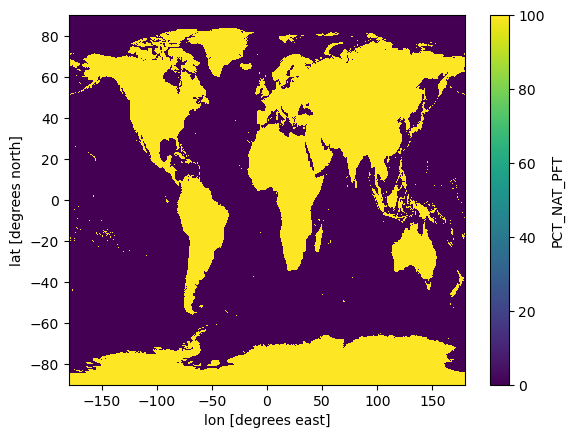

In [23]:
ds_forest.PCT_NAT_PFT.sum(dim='natpft').plot()

Excluding the bareground pft excludes the expected regions

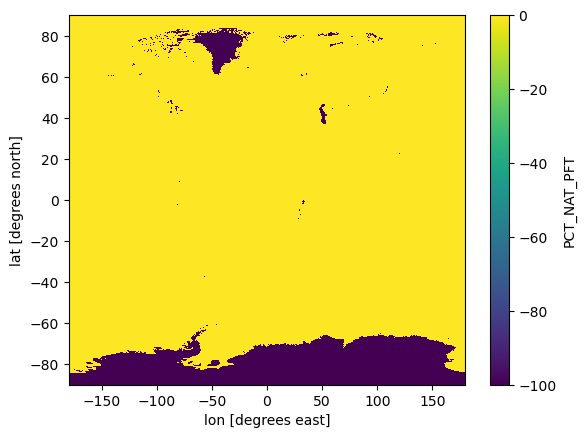

In [28]:
(ds_forest.PCT_NAT_PFT.isel(natpft=slice(1,None)).sum(dim='natpft') - ds_forest.PCT_NAT_PFT.sum(dim='natpft')).plot()

## Regrid the data

In [16]:
regridder = xe.Regridder(ds_forest,ds_target,'conservative')
ds_regrid = regridder(ds_forest)

/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


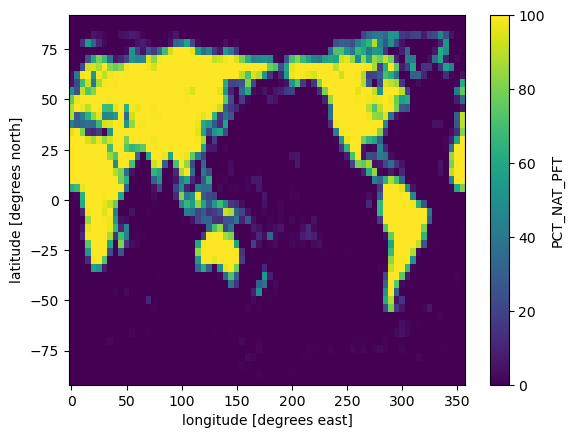

In [17]:
ds_regrid.PCT_NAT_PFT.isel(natpft=slice(1,None)).sum(dim='natpft').plot()

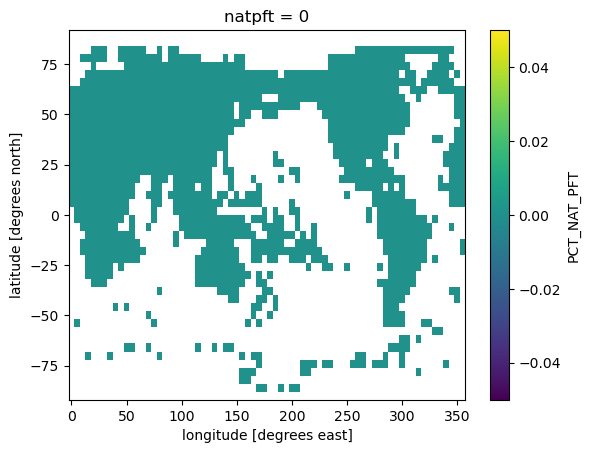

In [18]:
ds_regrid.PCT_NAT_PFT.isel(natpft=0).plot()